In [ ]:
pip install pyarrow

In [ ]:
pip install scikit-learn
pip install --upgrade numpy pandas scikit-learn

In [ ]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 14.5 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/usr/local/easybuild_allnodes/software/Python/3.10.4-GCCcore-11.3.0/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
parquet_file_path = '/home/hxk831/Personal Projects/train1.parquet'
train = pd.read_parquet(parquet_file_path)


# DATA PARTITION

1. Split data based on time line i.e t,t-1,t-2,t-3

2. t-2 will be train,Validation and t-3 will be test.

3. t-1, t will be used for prediction and track data drift and track models performance

In [ ]:
train = train.groupby('customer_ID').tail(4)
train

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
10,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-01-11,0.909668,0.005714,0.002829,1.004883,0.008179,0.098877,0.001853,0.003239,...,NaN,NaN,0.000427,0.004593,0.003613,NaN,0.007568,0.003004,0.006363,0
23,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-01-26,0.880859,0.211670,0.010582,1.001953,0.005955,0.130127,0.003628,0.002802,...,NaN,NaN,0.007275,0.008972,0.002497,NaN,0.003979,0.006626,0.002178,0
36,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-01-12,0.899414,0.004372,0.003450,0.813965,0.007408,NaN,0.008377,0.003839,...,NaN,NaN,0.009117,0.003887,0.000715,NaN,0.007706,0.009415,0.000563,0
49,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2018-01-18,0.614746,0.002249,0.025116,0.968750,0.009651,0.302979,0.007492,0.008408,...,NaN,NaN,0.002382,0.003796,0.000638,NaN,0.009453,0.004791,0.000834,0
62,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2018-01-30,0.881348,0.000722,0.009804,0.813477,0.009079,NaN,0.005905,0.000049,...,NaN,NaN,0.002579,0.001665,0.000579,NaN,0.004662,0.002550,0.009651,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531396,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,2018-01-16,0.837891,0.008263,0.013161,1.006836,0.005756,0.133911,0.005955,0.007393,...,NaN,NaN,0.008492,0.001622,0.009659,NaN,0.005005,0.008423,0.002531,0
5531409,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,2018-01-22,0.856445,0.036163,0.319092,0.044739,0.008858,NaN,0.005020,0.256104,...,NaN,NaN,0.002531,0.007389,0.003149,NaN,0.007442,0.005508,0.002928,0
5531422,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,2018-01-11,0.794434,0.384766,0.027100,1.000977,0.005398,0.075806,0.000377,0.004890,...,NaN,NaN,NaN,0.000498,NaN,NaN,NaN,0.004906,NaN,0
5531435,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,2018-01-25,0.787598,0.030945,0.015511,0.209473,0.008003,0.609375,0.008972,0.083679,...,NaN,NaN,1.009766,0.008911,0.940918,0.433838,1.002930,0.007103,0.182617,1


In [ ]:
train['S_2'] = pd.to_datetime(train['S_2'])
pred2 = train[(train['S_2'].dt.year == 2018) & (train['S_2'].dt.month == 3)]
pred1 = train[(train['S_2'].dt.year == 2018) & (train['S_2'].dt.month == 2)]
train1 = train[(train['S_2'].dt.year == 2018) & (train['S_2'].dt.month == 1)]

In [ ]:
train1 = train.copy()

# 1. DATA QUALITY

In [ ]:
for col in train1.columns:
    print(f"{col}: {train1[col].dtype}")

customer_ID: object
S_2: datetime64[ns]
P_2: float16
D_39: float16
B_1: float16
B_2: float16
R_1: float16
S_3: float16
D_41: float16
B_3: float16
D_42: float16
D_43: float16
D_44: float16
B_4: float16
D_45: float16
B_5: float16
R_2: float16
D_46: float16
D_47: float16
D_48: float16
D_49: float16
B_6: float16
B_7: float16
B_8: float16
D_50: float16
D_51: float16
B_9: float16
R_3: float16
D_52: float16
P_3: float16
B_10: float16
D_53: float16
S_5: float16
B_11: float16
S_6: float16
D_54: float16
R_4: float16
S_7: float16
B_12: float16
S_8: float16
D_55: float16
D_56: float16
B_13: float16
R_5: float16
D_58: float16
S_9: float16
B_14: float16
D_59: float16
D_60: float16
D_61: float16
B_15: float16
S_11: float16
D_62: float16
D_63: category
D_64: category
D_65: float16
B_16: float16
B_17: float16
B_18: float16
B_19: float16
D_66: float64
B_20: float16
D_68: float64
S_12: float16
R_6: float16
S_13: float16
B_21: float16
D_69: float16
B_22: float16
D_70: float16
D_71: float16
D_72: float16
S

This columns are categorical columns

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [ ]:
def to_categorical(df, categorical_cols):
    for col in categorical_cols:
        if col in df.columns:
            df[col] = pd.Categorical(df[col])
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    return df

categorical_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
train1 = to_categorical(train1, categorical_cols)

In [ ]:
train1[['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446255 entries, 10 to 5531448
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   B_30    446113 non-null  category
 1   B_38    446113 non-null  category
 2   D_114   432283 non-null  category
 3   D_116   432283 non-null  category
 4   D_117   432283 non-null  category
 5   D_120   432283 non-null  category
 6   D_126   446255 non-null  category
 7   D_63    446255 non-null  category
 8   D_64    446255 non-null  category
 9   D_66    49788 non-null   category
 10  D_68    429353 non-null  category
dtypes: category(11)
memory usage: 8.1 MB


In [ ]:
train_data_quality  = pd.DataFrame({'Missing values':train1.isnull().sum(),'Percentage of missing': (train1.isnull().sum()/len(train))*100,'Data Type':train1.dtypes})
train_data_quality.sort_values('Percentage of missing',ascending=False)

,Missing values,Percentage of missing,Data Type
D_87,445942,99.929861,float16
D_88,445707,99.877200,float16
D_108,444090,99.514851,float16
D_111,442892,99.246395,float16
D_110,442892,99.246395,float16
...,...,...,...
B_24,0,0.000000,float16
D_75,0,0.000000,float16
P_4,0,0.000000,float16
B_23,0,0.000000,float16


In [ ]:
train_data_quality[train_data_quality['Data Type'] == 'category']


,Missing values,Percentage of missing,Data Type
D_63,0,0.000000,category
D_64,0,0.000000,category
D_66,396467,88.843150,category
D_68,16902,3.787521,category
B_30,142,0.031820,category
B_38,142,0.031820,category
D_114,13972,3.130945,category
D_116,13972,3.130945,category
D_117,13972,3.130945,category
D_120,13972,3.130945,category


In [ ]:
train1.shape # Unique customers

(446255, 191)

# 2. EDA Refer other notebook

# 3. IDENTIFYING STRATERGY FOR OUTLIER DETECTION AND FILLING MISSING VALUES

1. I am deciding my stratergy to either first remove outliers and perform imputation or vise verca

2. Secondly, I want to build pipeline for the handelling during deployment.

  A. One pipeline start with Imputation and then Outlier Handling

  B. Other Pipeline with Outlier Handling first and then Imputation

  C. Decide and finalize which approach has better validation results

<Axes: >

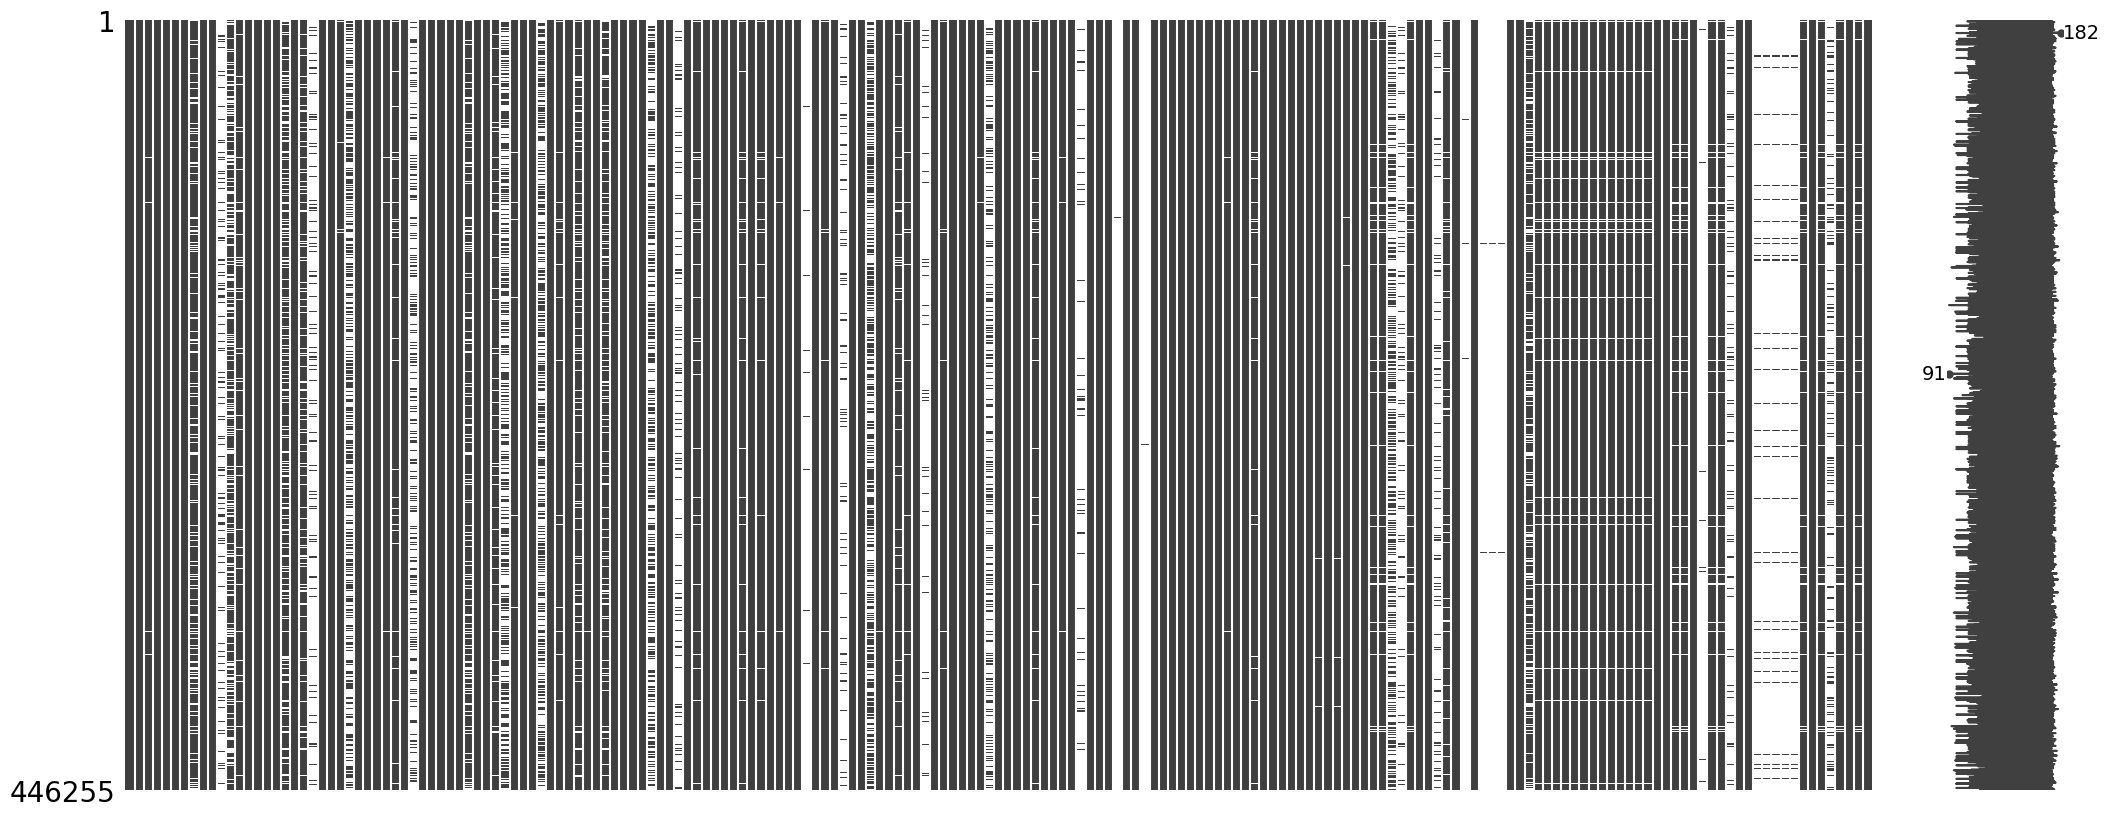

In [ ]:
import missingno as msno
msno.matrix(train1)


# IMPUTATION STRATERGY
*

In [ ]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


categorical_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126',
                    'D_63', 'D_64', 'D_66', 'D_68']
non_processed_cols = ['S_2', 'customer_ID', 'target']
continuous_cols = [col for col in train1.columns if col not in categorical_cols + non_processed_cols]

# Step 1: Define the imputers
continuous_imputer = IterativeImputer(max_iter=10, random_state=42, initial_strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Step 2: Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('continuous', continuous_imputer, continuous_cols),
        ('categorical', categorical_imputer, categorical_cols)
    ]
)

# Step 3: Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Step 4: Fit the pipeline and transform the data
train1_imputed_array = pipeline.fit_transform(train1)

transformed_columns = continuous_cols + categorical_cols

train1_imputed = pd.DataFrame(train1_imputed_array, columns=transformed_columns)

# Step 5: Add back non-processed columns
train1_imputed[non_processed_cols] = train1[non_processed_cols].reset_index(drop=True)

# Step 6: Ensure data types are preserved for categorical columns
for col in categorical_cols:
    train1_imputed[col] = train1_imputed[col].astype(train1[col].dtype)


print("Training Data (Preprocessed):")
print(train1_imputed.head())


# 4. FEATURE SELECTION

1. Identify features using Weight of Evidence, Information Value Gain, Mutual Information, Tree based Models

2. Based on the features identified, use Average Rank based Approach, and Frequency based Approach and select subset of the features.


# INFORMATION GAIN / MUTUAL INFORMATION

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


X = train1_imputed.drop(columns=['customer_ID', 'S_2', 'target'])
y = train1_imputed['target']

# Encode categorical variables using LabelEncoder
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Compute Mutual Information
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)


mi_scores = pd.Series(mi_scores, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)


plt.figure(figsize=(12, 6))
mi_scores.head(20).plot.bar()
plt.title('Top 20 Features by Mutual Information')
plt.ylabel('Mutual Information Score')
plt.show()


In [ ]:
selected_features_mi = mi_scores.head(75).index.tolist()

# WEIGHT OF EVIDEMCE & INFORMATION VALUE

In [ ]:
# Function to calculate WoE and IV
def calc_woe_iv(data, feature, target):
    eps = 1e-10  # Small value to avoid division by zero
    df = data[[feature, target]].copy()
    df['bin'] = df[feature]

    total_good = (df[target] == 0).sum()
    total_bad = (df[target] == 1).sum()

    grouped = df.groupby('bin')[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'bad']
    grouped['good'] = grouped['total'] - grouped['bad']
    grouped['bad_rate'] = grouped['bad'] / total_bad
    grouped['good_rate'] = grouped['good'] / total_good
    grouped['WoE'] = np.log((grouped['good_rate'] + eps) / (grouped['bad_rate'] + eps))
    grouped['IV'] = (grouped['good_rate'] - grouped['bad_rate']) * grouped['WoE']

    iv = grouped['IV'].sum()
    return iv, grouped['WoE']


iv_dict = {}
woe_dict = {}

from sklearn.preprocessing import KBinsDiscretizer

for col in continuous_cols:
    # Bin the variable into 10 quantiles
    est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
    binned = est.fit_transform(train1_imputed[[col]])
    train1_imputed[f'{col}_binned'] = binned

    # Calculate WoE and IV
    iv, woe = calc_woe_iv(train1_imputed, f'{col}_binned', 'target')
    iv_dict[col] = iv
    woe_dict[col] = woe

# For categorical variables
for col in categorical_cols:
    iv, woe = calc_woe_iv(train1_imputed, col, 'target')
    iv_dict[col] = iv
    woe_dict[col] = woe

iv_values = pd.Series(iv_dict).sort_values(ascending=False)

# Plot IV values
plt.figure(figsize=(12, 6))
iv_values.head(20).plot.bar()
plt.title('Top 20 Features by Information Value')
plt.ylabel('Information Value')
plt.show()


In [ ]:
selected_features_iv = iv_values[iv_values >= 0.05].index.tolist()

# XGBOOST FEATURE SELECTION

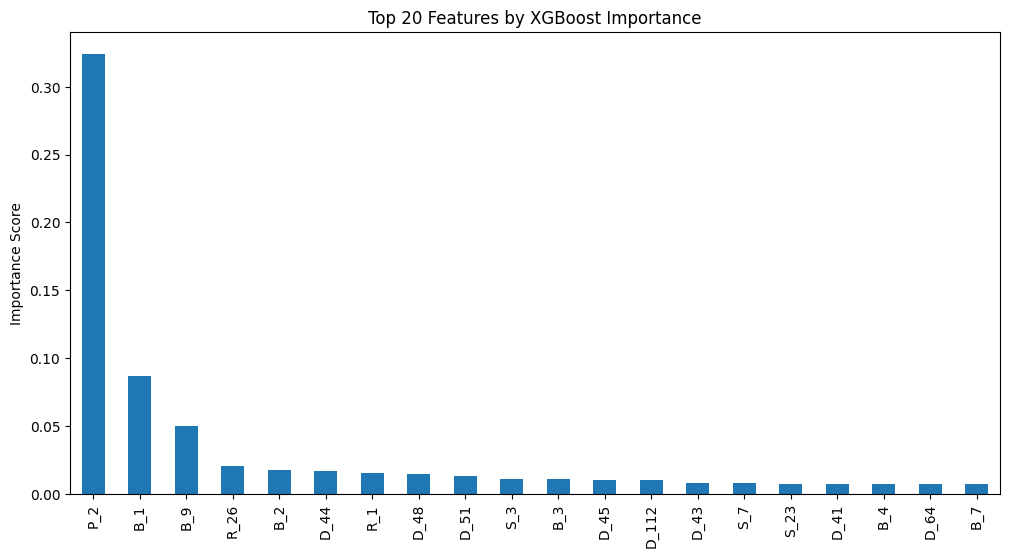

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Step 1: Remove binned columns from the DataFrame
binned_cols = [col for col in train1_imputed.columns if col.endswith('_binned')]
train1_imputed = train1_imputed.drop(columns=binned_cols)

# Step 2: Prepare the feature set
X = train1_imputed.drop(columns=['S_2', 'target'])
y = train1_imputed['target']

# Step 3: Encode categorical variables using LabelEncoder
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Step 4: Ensure all columns are numeric
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Handle any remaining object-type columns
object_cols = X.select_dtypes(include=['object']).columns.tolist()
if object_cols:
    print("Warning: The following columns are still of object dtype and will be excluded:", object_cols)
    X = X.drop(columns=object_cols)

# Step 5: Initialize XGBoost model without 'use_label_encoder' parameter
model = XGBClassifier(eval_metric='logloss', random_state=42)

# Step 6: Train the model
model.fit(X, y)

# Step 7: Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# Step 8: Plot feature importances
plt.figure(figsize=(12, 6))
importances.head(20).plot.bar()
plt.title('Top 20 Features by XGBoost Importance')
plt.ylabel('Importance Score')
plt.show()

# Step 9: Select top features
selected_features_tree = importances.head(50).index.tolist()


In [ ]:
selected_features_tree = importances.head(50).index.tolist()

In [ ]:
# Intersection of features
selected_features = list(set(selected_features_mi) & set(selected_features_iv) & set(selected_features_tree))
selected_features

['R_3',
 'D_110',
 'B_1',
 'D_51',
 'D_44',
 'D_62',
 'D_56',
 'S_24',
 'S_3',
 'B_11',
 'D_106',
 'D_43',
 'D_114',
 'B_2',
 'D_47',
 'D_50',
 'D_64',
 'B_8',
 'B_9',
 'D_77',
 'D_39',
 'B_38',
 'S_23',
 'P_2',
 'B_3',
 'B_4',
 'D_45',
 'B_7',
 'S_9',
 'B_14',
 'R_1',
 'P_3',
 'B_16',
 'B_37',
 'D_48',
 'R_26',
 'D_41',
 'S_7']

In [ ]:
len(selected_features) #Intersection

141

In [ ]:
# Union of features
selected_features = list(set(selected_features_mi) | set(selected_features_iv) | set(selected_features_tree))
selected_features

['B_7',
 'D_112',
 'S_6',
 'D_61',
 'D_88',
 'D_105',
 'S_7',
 'P_3',
 'S_23',
 'D_64',
 'B_3',
 'D_110',
 'D_74',
 'D_70',
 'D_87',
 'D_78',
 'D_126',
 'D_60',
 'D_84',
 'P_2',
 'D_103',
 'R_10',
 'D_145',
 'B_5',
 'D_136',
 'D_65',
 'S_3',
 'D_76',
 'D_52',
 'D_118',
 'D_117',
 'B_37',
 'B_1',
 'D_58',
 'D_75',
 'D_138',
 'B_14',
 'D_53',
 'D_113',
 'R_7',
 'B_29',
 'B_42',
 'R_6',
 'R_27',
 'S_8',
 'D_39',
 'D_63',
 'D_106',
 'D_51',
 'B_6',
 'B_19',
 'D_79',
 'D_41',
 'D_121',
 'R_1',
 'D_50',
 'B_39',
 'D_49',
 'S_26',
 'D_141',
 'D_130',
 'S_22',
 'D_62',
 'D_132',
 'D_119',
 'B_18',
 'S_9',
 'D_56',
 'D_111',
 'D_104',
 'D_139',
 'B_22',
 'S_11',
 'D_42',
 'P_4',
 'B_38',
 'D_114',
 'D_92',
 'S_24',
 'B_11',
 'B_23',
 'D_59',
 'B_10',
 'D_142',
 'D_91',
 'B_33',
 'B_28',
 'D_102',
 'D_143',
 'B_16',
 'B_26',
 'D_82',
 'B_13',
 'D_127',
 'D_120',
 'D_68',
 'D_43',
 'S_25',
 'B_31',
 'B_20',
 'R_2',
 'D_81',
 'D_44',
 'R_16',
 'D_129',
 'B_9',
 'D_73',
 'D_107',
 'D_47',
 'R_4',
 

In [ ]:
len(selected_features) #Union

141

In [ ]:
# This data is been imputed.

parquet_file_path = '/home/hxk831/Personal Projects/train1_imputed.parquet'
train1_imputed_df = pd.read_parquet(parquet_file_path)


In [ ]:
train1_imputed_df

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_117,D_120,D_126,D_63,D_64,D_66,D_68,S_2,customer_ID,target
0,0.909668,0.005714,0.002829,1.004883,0.008179,0.098877,0.001853,0.003239,1.113281,0.024063,...,4.0,0.0,1.0,CR,O,1.0,6.0,2018-01-11,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,0.880859,0.211670,0.010582,1.001953,0.005955,0.130127,0.003628,0.002802,0.482178,0.065247,...,-1.0,1.0,1.0,CO,O,1.0,6.0,2018-01-26,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,0.899414,0.004372,0.003450,0.813965,0.007408,0.296875,0.008377,0.003839,0.569336,0.038391,...,-1.0,0.0,1.0,CO,R,1.0,6.0,2018-01-12,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,0.614746,0.002249,0.025116,0.968750,0.009651,0.302979,0.007492,0.008408,0.415039,0.052521,...,6.0,0.0,1.0,CO,O,1.0,3.0,2018-01-18,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,0.881348,0.000722,0.009804,0.813477,0.009079,0.297852,0.005905,0.000049,0.382324,0.043671,...,4.0,0.0,1.0,CO,O,1.0,6.0,2018-01-30,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446250,0.837891,0.008263,0.013161,1.006836,0.005756,0.133911,0.005955,0.007393,0.348877,0.130737,...,4.0,1.0,1.0,CO,U,1.0,6.0,2018-01-16,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,0
446251,0.856445,0.036163,0.319092,0.044739,0.008858,0.325439,0.005020,0.256104,1.014648,0.041016,...,2.0,0.0,1.0,CO,R,1.0,6.0,2018-01-22,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,0
446252,0.794434,0.384766,0.027100,1.000977,0.005398,0.075806,0.000377,0.004890,0.449219,0.054230,...,-1.0,0.0,1.0,CO,U,1.0,5.0,2018-01-11,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,0
446253,0.787598,0.030945,0.015511,0.209473,0.008003,0.609375,0.008972,0.083679,0.383057,0.049744,...,-1.0,0.0,1.0,CO,R,1.0,3.0,2018-01-25,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,1


In [ ]:
# Simple sampling with stratification
sampled_data = train1_imputed_df.groupby('target', group_keys=False).apply(
    lambda x: x.sample(frac=0.3, random_state=42)
)

# Verify the distribution
print("Original Target Distribution:")
print(train1_imputed_df['target'].value_counts(normalize=True))
print("\nSampled Target Distribution:")
print(sampled_data['target'].value_counts(normalize=True))


Original Target Distribution:
0    0.742824
1    0.257176
Name: target, dtype: float64

Sampled Target Distribution:
0    0.742824
1    0.257176
Name: target, dtype: float64


In [ ]:
selected_features = ['D_105',
 'D_53',
'D_42',
'D_77',
'D_47',
'S_6',
'D_110',
'P_2',
'R_1',
'D_81',
'D_87',
'D_72',
'D_49',
'B_40',
'D_129',
'D_60',
'S_27',
'D_55',
'D_130',
'R_4',
'D_136',
'R_3',
'D_104',
'D_131',
'B_30',
'D_139',
'B_10',
'B_37',
'D_106',
'S_8',
'D_63',
'R_2',
'D_56',
'B_25',
'D_45',
'B_12',
'D_112',
'B_33',
'S_11',
'D_134',
'B_9',
'D_54',
'D_68',
'D_142',
'D_62',
'D_74',
'D_76',
'B_11',
'D_107',
'D_113',
'D_51',
'P_4',
'D_145',
'D_133',
'R_9',
'D_73',
'S_26',
'D_64',
'B_8',
'D_127',
'D_103',
'D_59',
'B_22',
'S_9',
'S_25',
'D_118',
'B_28',
'D_121',
'B_23',
'D_126',
'R_26',
'B_7',
'D_111',
'D_61',
'P_3',
'D_141',
'S_3',
'S_22',
'D_91',
'D_102',
'B_13',
'B_18',
'D_71',
'R_10',
'S_13',
'S_23',
'D_117',
'D_75',
'S_24',
'D_84',
'B_1',
'D_114',
'R_7',
'D_82',
'D_88',
'D_128',
'D_79',
'B_39',
'D_44',
'D_58',
'D_70',
'B_2',
'B_20',
'B_17',
'D_39',
'B_4',
'B_14',
'D_78',
'D_43',
'B_29',
'B_38',
'B_5',
'S_5',
'B_19',
'D_132',
'R_8',
'B_3',
'B_26',
'D_52',
'D_48',
'D_65',
'D_138',
'R_27',
'D_122',
'B_6',
'D_92',
'R_5',
'R_6',
'D_143',
'D_41',
'S_15',
'D_115',
'B_16',
'D_46',
'S_7',
'B_42',
'B_31',
'D_120',
'D_50',
'R_16',
'D_119']



# MODEL BUILDING

1. Random Forest

2. XGBOOST

4. Light boost

3. SVM

In [ ]:
# Prepare the data
X = sampled_data[selected_features]
y = sampled_data['target']



In [ ]:
# Identify categorical variables in X
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns to encode:", categorical_cols)



Categorical columns to encode: ['D_63', 'D_64']


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize a LabelEncoder for each categorical column
label_encoders = {}

# Encode categorical variables
for col in categorical_cols:
    le = LabelEncoder()
    # Convert to string type to handle mixed data types
    X[col] = le.fit_transform(X[col].astype(str))
    # Store the encoder for potential inverse transformation or future use
    label_encoders[col] = le


/tmp/job.2281455.hpc/ipykernel_123603/2151891621.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/tmp/job.2281455.hpc/ipykernel_123603/2151891621.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)



# RANDOM FOREST

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define hyperparameters
rf = RandomForestClassifier(
    n_estimators=200,  # Number of trees
    max_depth=20,      # Maximum depth of the trees
    max_features='sqrt',  # Features to consider at each split
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]



In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test ROC-AUC Score: {roc_auc:.4f}")

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))




Test Accuracy: 0.8778
Test ROC-AUC Score: 0.9408

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     19890
           1       0.77      0.76      0.76      6886

    accuracy                           0.88     26776
   macro avg       0.84      0.84      0.84     26776
weighted avg       0.88      0.88      0.88     26776



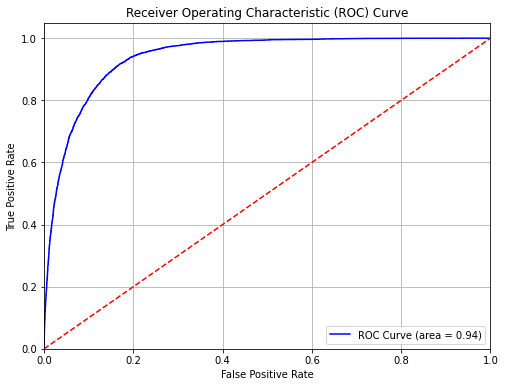

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


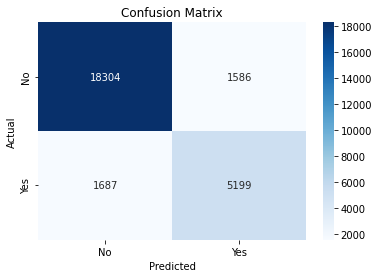

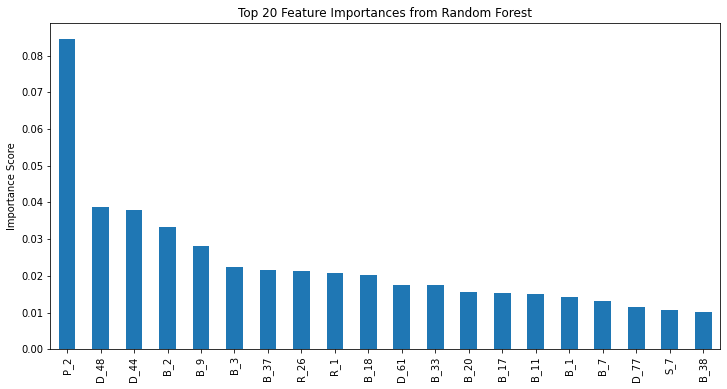

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Step 10: Feature Importance
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

# Plot top 20 feature importances
plt.figure(figsize=(12, 6))
importances.head(20).plot.bar()
plt.title('Top 20 Feature Importances from Random Forest')
plt.ylabel('Importance Score')
plt.show()

# SVM

I have done hyper parameter tuninng in other note book, and i am using the parameters over here

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


svm = SVC(C=1, kernel='rbf', gamma='scale', probability=True, random_state=42)
svm.fit(X_train, y_train)

# Evaluate the model
y_pred = svm.predict(X_test)
y_proba = svm.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)



ROC-AUC Score: 0.9410120038823917
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     29835
           1       0.77      0.75      0.76     10329

    accuracy                           0.88     40164
   macro avg       0.84      0.84      0.84     40164
weighted avg       0.88      0.88      0.88     40164



/tmp/job.2281455.hpc/ipykernel_119429/3044002438.py:32: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


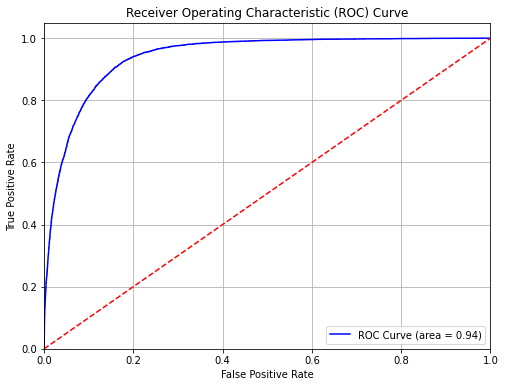

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     29835
           1       0.77      0.75      0.76     10329

    accuracy                           0.88     40164
   macro avg       0.84      0.84      0.84     40164
weighted avg       0.88      0.88      0.88     40164



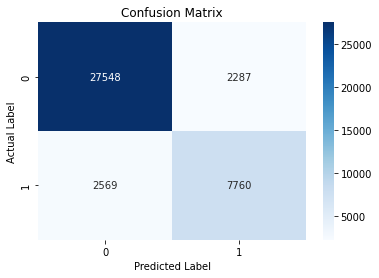

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


# LGBOOST

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    random_state=42,
    scale_pos_weight=3,  # Handles class imbalance
    n_estimators=100,    # Number of boosting iterations
    learning_rate=0.1,   # Learning rate
    max_depth=6          # Limits the depth of each tree to avoid overfitting
)

lgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = lgb_model.predict(X_test)
y_proba = lgb_model.predict_proba(X_test)[:, 1]



[LightGBM] [Info] Number of positive: 24101, number of negative: 69612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32971
[LightGBM] [Info] Number of data points in the train set: 93713, number of used features: 140
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.257179 -> initscore=-1.060684
[LightGBM] [Info] Start training from score -1.060684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



ROC-AUC Score: 0.9444278218944636

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90     29835
           1       0.67      0.91      0.77     10329

    accuracy                           0.86     40164
   macro avg       0.82      0.88      0.84     40164
weighted avg       0.89      0.86      0.87     40164



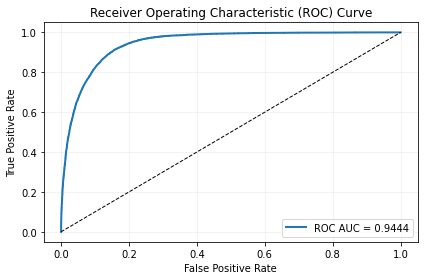

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90     29835
           1       0.67      0.91      0.77     10329

    accuracy                           0.86     40164
   macro avg       0.82      0.88      0.84     40164
weighted avg       0.89      0.86      0.87     40164



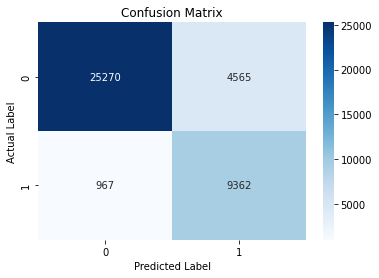

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


# XGBOOST

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',        # Suitable for binary classification
    learning_rate=0.1,            # Step size shrinkage
    n_estimators=200,             # Number of boosting rounds
    max_depth=6,                  # Maximum depth of a tree
    subsample=0.8,                # Randomly sample 80% of the data for growing trees
    colsample_bytree=0.8,         # Use 80% of features for growing trees
    scale_pos_weight=3,           # Handle class imbalance
    random_state=42               # Ensure reproducibility
)


xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]




In [ ]:
# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



ROC-AUC Score: 0.9456035314473578

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     19890
           1       0.69      0.89      0.78      6886

    accuracy                           0.87     26776
   macro avg       0.83      0.88      0.84     26776
weighted avg       0.89      0.87      0.87     26776



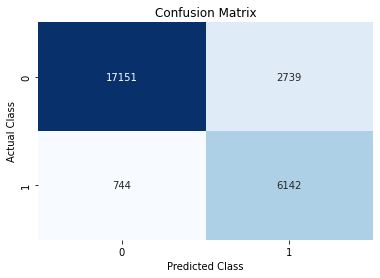

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()



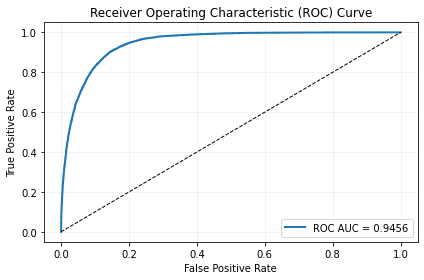

In [ ]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# LOGISTIC REGRESSION

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

log_reg = LogisticRegression(
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    max_iter=1000             # Ensure convergence for larger datasets
)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]



In [ ]:
# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



ROC-AUC Score: 0.9416270430991973

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90     29835
           1       0.68      0.89      0.77     10329

    accuracy                           0.86     40164
   macro avg       0.82      0.87      0.84     40164
weighted avg       0.89      0.86      0.87     40164



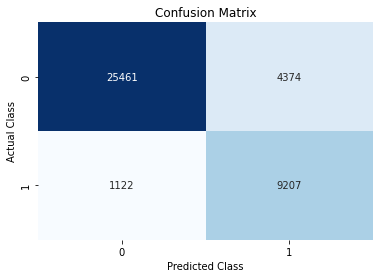

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

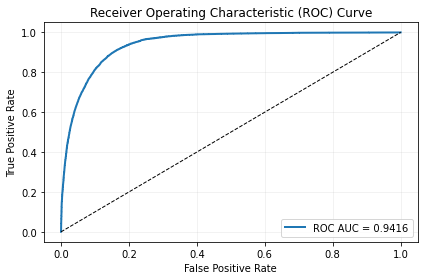

In [ ]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# MODEL COMPARISION

# 1. GINI COEFFICIENT

In [ ]:
gini_coefficient_log = 2 * 0.9416270430991973 - 1
print("Gini Coefficient Logistic:", gini_coefficient_log)
gini_coefficient_lgb = 2 * 0.9444278218944636 - 1
print("Gini Coefficient LightBoostc:", gini_coefficient_lgb)
gini_coefficient_svm = 2 * 0.9410120038823917 - 1
print("Gini Coefficient SVM:", gini_coefficient_svm)
gini_coefficient_rf = 2 * 0.94080120038823917 - 1
print("Gini Coefficient RF:", gini_coefficient_rf)
gini_coefficient_xgboost = 2 * 0.94080120038823917 - 1
print("Gini Coefficient XGBoost:", gini_coefficient_xgboost)

Gini Coefficient Logistic: 0.8832540861983946
Gini Coefficient LightBoostc: 0.8888556437889272
Gini Coefficient SVM: 0.8820240077647834
Gini Coefficient RF: 0.8816024007764784
Gini Coefficient XGBoost: 0.8816024007764784


In [1]:
import pandas as pd

# Calculate Gini coefficients for each model
gini_coefficient_log = 2 * 0.9416270430991973 - 1
gini_coefficient_lgb = 2 * 0.9444278218944636 - 1
gini_coefficient_svm = 2 * 0.9410120038823917 - 1
gini_coefficient_rf = 2 * 0.94080120038823917 - 1
gini_coefficient_xgboost = 2 * 0.94080120038823917 - 1

gini_data = {
    'Model': ['Logistic Regression', 'LightGBM', 'SVM', 'Random Forest', 'XGBoost'],
    'Gini Coefficient': [
        gini_coefficient_log,
        gini_coefficient_lgb,
        gini_coefficient_svm,
        gini_coefficient_rf,
        gini_coefficient_xgboost
    ]
}


gini_df = pd.DataFrame(gini_data)
gini_df['Gini Coefficient'] = gini_df['Gini Coefficient'].round(2)
gini_df

,Model,Gini Coefficient
0,Logistic Regression,0.88
1,LightGBM,0.89
2,SVM,0.88
3,Random Forest,0.88
4,XGBoost,0.88


# 2. Precision, Recall, F1-SCORE

In [ ]:
import pandas as pd

data = {
    'Model': ['Random Forest', 'SVM', 'LightGBM', 'XGBoost', 'Logistic Regression'],
    'Precision': [0.77, 0.77, 0.67, 0.69, 0.68],  # Precision for class 1
    'Recall': [0.76, 0.75, 0.91, 0.89, 0.89],      # Recall for class 1
    'F1 Score': [0.76, 0.76, 0.77, 0.78, 0.77],    # F1 Score for class 1
    'ROC-AUC Score': [0.9408, 0.9410120038823917, 0.9444278218944636, 0.9456035314473578, 0.9416270430991973],
    'Test Accuracy': [0.8778, 0.88, 0.86, 0.87, 0.86]
}

metrics_df = pd.DataFrame(data)
metrics_df['ROC-AUC Score'] = metrics_df['ROC-AUC Score'].round(2)
metrics_df['Test Accuracy'] = metrics_df['Test Accuracy'].round(2)
metrics_df

,Model,Precision,Recall,F1 Score,ROC-AUC Score,Test Accuracy
0,Random Forest,0.77,0.76,0.76,0.94,0.88
1,SVM,0.77,0.75,0.76,0.94,0.88
2,LightGBM,0.67,0.91,0.77,0.94,0.86
3,XGBoost,0.69,0.89,0.78,0.95,0.87
4,Logistic Regression,0.68,0.89,0.77,0.94,0.86


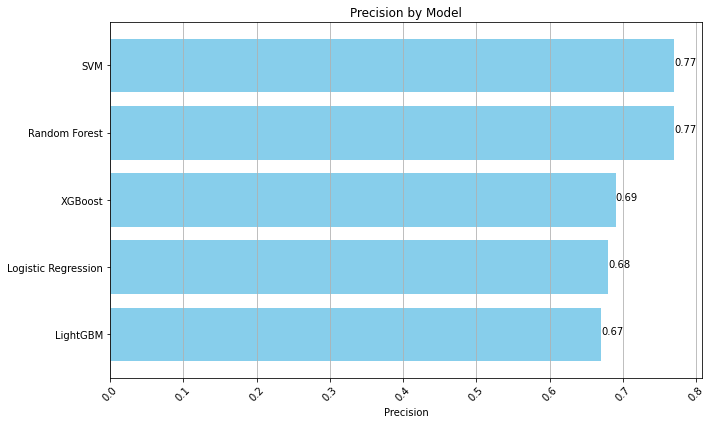

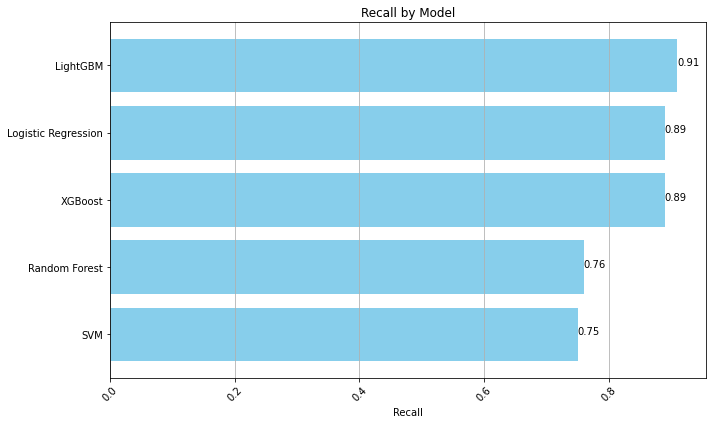

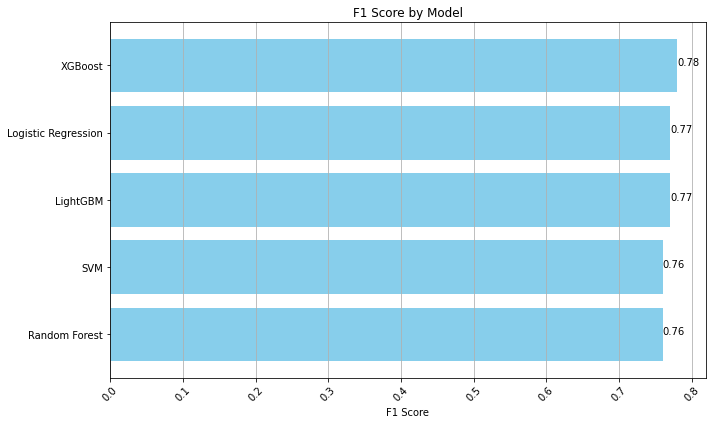

In [ ]:
def plot_metric(metric_name):

    sorted_df = metrics_df.sort_values(by=metric_name)

    plt.figure(figsize=(10, 6))
    plt.barh(sorted_df['Model'], sorted_df[metric_name], color='skyblue')
    plt.xlabel(metric_name)
    plt.title(f'{metric_name} by Model')
    plt.xticks(rotation=45)
    plt.grid(axis='x')


    for index, value in enumerate(sorted_df[metric_name]):
        plt.text(value, index, f"{value:.2f}")

    plt.tight_layout()
    plt.show()


plot_metric('Precision')
plot_metric('Recall')
plot_metric('F1 Score')

In [ ]:
false_negatives_data = {
    'Model': ['Random Forest', 'SVM', 'LightGBM', 'XGBoost', 'Logistic Regression'],
    'False Negatives': [1660, 2582, 939, 758, 1076]
}

false_negatives_df = pd.DataFrame(false_negatives_data)
false_negatives_df

,Model,False Negatives
0,Random Forest,1660
1,SVM,2582
2,LightGBM,939
3,XGBoost,758
4,Logistic Regression,1076


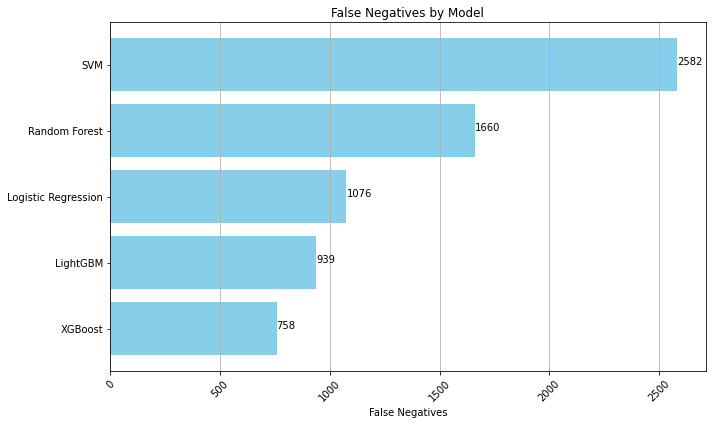

In [ ]:

false_negatives_df = false_negatives_df.sort_values(by='False Negatives')
plt.figure(figsize=(10, 6))
plt.barh(false_negatives_df['Model'], false_negatives_df['False Negatives'], color='skyblue')
plt.xlabel('False Negatives')
plt.title('False Negatives by Model')
plt.xticks(rotation=45)
plt.grid(axis='x')

for index, value in enumerate(false_negatives_df['False Negatives']):
    plt.text(value, index, str(value))


plt.tight_layout()
plt.show()

XGBoost emerges as the best model based on the following rationale:

1. F1 Score: XGBoost has the highest F1 Score (0.78), indicating a good balance between precision and recall. This suggests that it performs well in identifying positive instances while maintaining a reasonable rate of false positives.

2. Recall: XGBoost has a high recall (0.89), which means it is effective at capturing positive instances. This is especially important in where missing a positive case could have serious consequences here it is credit card default

3. ROC-AUC Score: It has the highest ROC-AUC Score (0.95), indicating excellent performance in distinguishing between classes across various thresholds.

4. Overall Performance: While its precision is slightly lower than that of Random Forest and SVM, the trade-off is justified given the higher recall and F1 Score.

This makes XGBoost a robust choice when the cost of false negatives is high

# FINAL MODEL XGBOOST / MAKING PREDICTIONS AND EVALUATING ON UNSEEN DATA - Refer Deployment Files

In [ ]:
test1 = preprocess_test_data(test, categorical_cols, datetime_col)
test2 = preprocess_test_data(test, categorical_cols, datetime_col)
test3 = preprocess_test_data(test, categorical_cols, datetime_col)
test4 = preprocess_test_data(test, categorical_cols, datetime_col)
test5 = preprocess_test_data(test, categorical_cols, datetime_col)
